<a href="https://colab.research.google.com/github/BrendanL72/Hospitalization-Risk/blob/main/CreateAppointments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!printf "ADLs\n"
!gdown -O outreachAdls.csv <put gdrive id here>
!printf "\nCRFs\n"
!gdown -O outreachCrfs.csv <put gdrive id here>

ADLs
usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY]
             [--speed SPEED] [--no-cookies] [--no-check-certificate]
             [--continue] [--folder] [--remaining-ok]
             url_or_id
gdown: error: the following arguments are required: url_or_id

CRFs
usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY]
             [--speed SPEED] [--no-cookies] [--no-check-certificate]
             [--continue] [--folder] [--remaining-ok]
             url_or_id
gdown: error: the following arguments are required: url_or_id


In [ ]:
import pandas as pd
import numpy as np
#import seaborn as sns
import math
import os
import datetime
import re
#from google.colab import drive
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
#drive.mount('/content/drive')

In [ ]:
adls = pd.read_csv('/content/outreachAdls.csv')
crfs = pd.read_csv('/content/outreachCrfs.csv')

print(f'{len(adls)} ADLs, {len(crfs)} CRFs')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


702569 ADLs, 600 CRFs


In [ ]:
runScratchSections = False

# Prepare data into machine readable format

In [ ]:
#CSP-4: Convert time data to object types 

#Convert in CRFs
#Cols to DR: Time (y), Date of Review (y)
#Cols to Bool: Any Hospitalizations (n), 
#Cols to 1 Hot: ? Which Review is this (n), ? Insurance (n), ? 
crfs['Date of Review'] = crfs['Date of Review'].transform(lambda x: datetime.datetime.strptime(x, "%d-%b-%y"))
crfs = crfs.drop(columns=['Time'])

#Convert in ADLs
#Cols: VisitDate, ActualTimeIn, ActualTimeOut, VisitDuration, SignatureDate
visitDurationRe = re.compile('^(?:(?P<hour>[0-9]+) h ?)?(?:(?P<minute>[0-9]+)m)?$')
def standardizeVisitDuration(durationStr):
  m = visitDurationRe.match(durationStr)
  return f"{m.group('hour') if m.group('hour') else 0} h {m.group('minute') if m.group('minute') else 0}m"

def parseTimedelta(string, template):
  time = datetime.datetime.strptime(string, template)
  return datetime.timedelta(hours=time.hour, minutes=time.minute, seconds=time.second)

adls['VisitDate'] = adls['VisitDate'].transform(lambda x: datetime.datetime.strptime(x, '%m/%d/%y'))
adls['ActualTimeIn'] = adls['ActualTimeIn'].transform(lambda x: datetime.datetime.strptime(x, '%H:%M'))
adls['ActualTimeOut'] = adls['ActualTimeOut'].transform(lambda x: datetime.datetime.strptime(x, '%H:%M'))
#Format VisitDuration into '%H h %Mm' from '%H h' or '%H h %Mm'
adls['VisitDuration'] = adls['VisitDuration'].transform(lambda x: parseTimedelta(standardizeVisitDuration(x), '%H h %Mm'))
#txtBreakTimesValue is all nan
adls['SignatureDate'] = adls['SignatureDate'].transform(lambda x: datetime.datetime.strptime(x, 'Signature Date: %m/%d/%Y %H:%M:%S %p') if len(x) != 16 else datetime.datetime(year=1, month=1, day=1))
adls = adls.drop(columns=['VisitDate2'])

In [ ]:
if runScratchSections:
  #CSP-5: Remove duplicate entries
  #TODO Fails on ADL with no

  #Df is a dataframe that data will be dropped from
  #DupFunc is a function that takes an index and returns a list of duplicate indices (excluding itsself)
  def dropDupsOnFunc(df, dupFunc, **kwargs):
    dups = {}
    for i in df.index:
      dups[i] = dupFunc(i, df)
    dups = pd.Series(data = dups, index = df.index)
    dups = dups.loc[dups.transform(lambda x: len(x) > 0)]
    if('print' in kwargs and kwargs['print'] and len(dups) > 0):
      print(f'Duplicates: {dups}')
    #Drop duplicates
    for i in dups.index:
      if i in dups:
        for j in dups[i]:
          if j in df.index:
            dups = dups.drop(j)
            df = df.drop(j)
    return df

  #CRFs
  #Need custom func for drop instead of drop_duplicates for custom criteria instead of pure dupe
  def findDuplicateCrf(crfIndex, crfSub):
    crfRow = crfs.iloc[crfIndex]
    cliCrfs = crfs.loc[crfs['Masked Client ID'] == crfRow['Masked Client ID']]
    return cliCrfs.loc[cliCrfs['Date of Review'] == crfRow['Date of Review']].index.drop(crfIndex)

  print(f'Initial length CRFs: {len(crfs)}')
  for c in crfs['Masked Client ID'].unique():
    crfs = dropDupsOnFunc(crfs.loc[crfs['Masked Client ID'] == c], findDuplicateCrf, print=True)
  print(f'Final len CRFs: {len(crfs)}')

  #ADLs
  #Need custom func for drop instead of drop_duplicates for custom criteria instead of pure dupe
  def findDuplicateAdl(adlIndex, adlSub):
    #Same 'DeIdentify ID', 'VisitDate', 'ScheduledTimeIn', 'ScheduledTimeOut', 'TaskCodeGroupName'
    adlRow = adlSub.iloc[adlIndex]
    sameAdls = adlSub.loc[adls['DeIdentify ID'] == adlRow['DeIdentify ID']]
    sameAdls = sameAdls.loc[sameAdls['VisitDate'] == sameAdls['VisitDate']]
    return sameAdls.loc[(sameAdls['ScheduledTimeIn'] == adlRow['ScheduledTimeIn']) &
                            (sameAdls['ScheduledTimeOut'] == adlRow['ScheduledTimeOut']) &
                            (sameAdls['TaskCodeGroupName'] == adlRow['TaskCodeGroupName'])
                        ].index.drop(adlIndex)

  print(f'Initial length ADLs: {len(adls)}')
  for c in adls['DeIdentify ID'].unique():
    adls = dropDupsOnFunc(adls.loc[adls['DeIdentify ID'] == c], findDuplicateAdl, print=True)
  print(f'Final len ADLs: {len(adls)}')
else:
  print('RunScratchSections is false')

RunScratchSections is false


In [ ]:
#CSP-4: Consolidate string data

#CRF Insurance
#Needs to be updated regularly so that insurance can be properly combined into a single value
insuranceCorrections = {'^Other': 'Other:', ',': 'And', '^And': '', 'And$': '', 'Healthcare': 'Health Care', 'Ins': 'Insurance', 'Ddd': 'DDD', 'Uhc': 'UHC', 'Va': 'VA', 'United Health Care': 'UHC', 'VA Program': 'VA', 'Marai': 'Marpai', '^Other: UHC$': 'UHC'}

def fromLooseInsuranceStr(form):
  ret = ' '.join([i[0].upper() + i[1:] for i in form.split(' ')])
  for k in insuranceCorrections:
    ret = re.sub(k, insuranceCorrections[k], ret)
  return ret

def toLooseInsuranceStr(unform):
  unform = re.sub('[^A-Za-z0-9 _,]', '', unform)
  unform = re.sub('[ _,]+', ' ', unform)
  unform = unform.lower().strip()
  return unform

def formatInsurance(ins):
  return fromLooseInsuranceStr(toLooseInsuranceStr(ins))

#Consolidates insurances given into similar
crfs['Insurance'] = crfs['Insurance'].transform(lambda x: formatInsurance(x))
#Consolidates singular insurance providers into an 'Other' category
crfs['Insurance'] = crfs['Insurance'].transform(lambda x: x if crfs['Insurance'].value_counts()[x] > 1 else 'Other')
#Combines DDD and DDD Ahcccs
crfs['Insurance'] = crfs['Insurance'].transform(lambda x: 'Other: DDD' if x == 'Other: DDD Ahcccs' else x)

In [ ]:
#CSP-4: Convert string data to objects
def isYes(val):
  return 1 if val == 'Yes' else 0

crfs['Any Hospitalizations in the last 30 days'] = crfs['Any Hospitalizations in the last 30 days'].transform(isYes)
crfs['Matrix (Do you worry about falling?)'] = crfs['Matrix (Do you worry about falling?)'].transform(isYes)
crfs['Matrix (Do you have a Living Will?)'] = crfs['Matrix (Do you have a Living Will?)'].transform(isYes)
crfs['Matrix (Do you have a  DNR?)'] = crfs['Matrix (Do you have a  DNR?)'].transform(isYes)
crfs['Do you have a POA'] = crfs['Do you have a POA'].transform(isYes)
crfs['Do you need help with DNR, Living Will or POA'] = crfs['Do you need help with DNR, Living Will or POA'].transform(isYes)
crfs['Are there any changes to your home environment since the last Intake/Review?'] = crfs['Are there any changes to your home environment since the last Intake/Review?'].transform(isYes)
crfs['Has anyone moved in our out in the last 30 days?'] = crfs['Has anyone moved in our out in the last 30 days?'].transform(isYes)
crfs['Are you receiving Home Health Services'] = crfs['Are you receiving Home Health Services'].transform(isYes)
crfs['Are you expecting a Nurse or Therapist to visit you at home?'] = crfs['Are you expecting a Nurse or Therapist to visit you at home?'].transform(isYes)
crfs['Any changes to Transportation needs?'] = crfs['Any changes to Transportation needs?'].transform(isYes)
crfs['Have you had any new DME equipment in the last 90 days?'] = crfs['Have you had any new DME equipment in the last 90 days?'].transform(isYes)
crfs['Do you need any DME Equipment?'] = crfs['Do you need any DME Equipment?'].transform(isYes)
crfs['Any new medical devises in the past 90 days'] = crfs['Any new medical devises in the past 90 days'].transform(isYes)
crfs['Any changes to Mental Status'] = crfs['Any changes to Mental Status'].transform(isYes)
crfs['Any new medical conditions in the last 90 days'] = crfs['Any new medical conditions in the last 90 days'].transform(isYes)
crfs['Have you had your flu shot this year?'] = crfs['Have you had your flu shot this year?'].transform(isYes)
crfs['Does your health plan meet your needs?'] = crfs['Does your health plan meet your needs?'].transform(isYes)
crfs['Has the Care Plan been reviewed with the Client'] = crfs['Has the Care Plan been reviewed with the Client'].transform(isYes)
crfs['Any changes to current care plan'] = crfs['Any changes to current care plan'].transform(isYes)
crfs['Does your Caregiver carry out the care plan satisfactory'] = crfs['Does your Caregiver carry out the care plan satisfactory'].transform(isYes)
crfs['Are the cargivers able to perform all the tasks on your care plan'] = crfs['Are the cargivers able to perform all the tasks on your care plan'].transform(isYes)
crfs['Are there any upcoming schedule changes?'] = crfs['Are there any upcoming schedule changes?'].transform(isYes)
crfs['Are you happy with the services being provided?'] = crfs['Are you happy with the services being provided?'].transform(isYes)

In [ ]:
#Convert CRFs to one-hot and remove free response data
toDrop = ['Note on Hospitalization (date and reason)', 'How can we help prevent a return to hospital?', 'Note on help needed?',
          'If so from which Agency', 'What will the Nurse/Therapist do?', 'Notes on transportation needs',
          'Notes on new DME equipment', 'Notes on DME Equipment needed', 'Notes on new medical devises',
          'Notes on changes to mental status', 'Notes on changes to medical conditions', 'Where and when did you have your flu shot?',
          'Date and Place of last HbA1C Check', 'Date and place of last Mammogram (if female)',
          'Date and place of last Colorectal Exam', 'Date and place of last time you had your cholesterol checked',
          'Date and place of last Bone Density Scan', 'Notes on changes to Care Plan', 'Details of timekeeping issues',
          'Detail any issues', 'Detail any issues.1', 'Details of Schedule changes', 'If No make notes here',
          'Any Questions or Concerns?', 'Case Manager Notes']
to1Hot = ['COVID -19', 'Which Review is this', 'Insurance', 'Have you fallen in:', 'Did your fall result in',
          'Condition of the Home', 'How is your vision?', 'How is your hearing', 'Do you take your medications',
          'Do you fill all your prescriptions?', 'How would you describe your diet',
          'How much water do you drink in a day?', 'How do you sleep',
          'What do you do about your medical appointments', 'Do your caregivers arrive on time?']
crfs = crfs.drop(columns=toDrop)
crfs = pd.get_dummies(crfs, columns=to1Hot)

In [ ]:
#TODO is performed on another day still counting as performed on a specific visit or will freq be affected?
#Chris does not think so, I think it should be excluded since it is not a unique task
doneReasons = ['Care Provided By Family or Friend or Self']
adls.insert(14, 'Performed', ((adls['HasBeenDone'] == 'Y') | (adls['Reason'].transform(lambda x: x in doneReasons))))

In [ ]:
#Convert adls for correlation

#AD HOC REMOVAL (SOME MAY BE SALVAGABLE)
#Remove adls with no tasks
adls = adls.loc[adls['TaskCodeGroupName'].transform(lambda x: isinstance(x, str))]
#Replace nan id with 0
adls['ProviderID'] = adls['ProviderID'].transform(lambda x: 0 if np.isnan(x) else x)

adls['HasBeenDone'] = adls['HasBeenDone'].transform(lambda x: 1 if x == 'Y' else 0)
adls['Performed'] = adls['Performed'].transform(lambda x: 1 if x else 0)
adlDropCols = ['PayerGroup', 'VisitDuration', 'txtBreakTimesValue', 'ScheduledTimeIn',
               'ScheduledTimeOut', 'Comments', 'NoSignature', 'SignatureRefusalReason',
               'RectangleVoiceCaptured', 'SignatureDate']
adlTo1Hot = ['ProviderID', 'ServiceTypeName', 'TaskCodeGroupName', 'Reason']
adls = adls.drop(columns=adlDropCols)
adls = pd.get_dummies(adls, columns=adlTo1Hot)

# Correlate and group data

In [ ]:
#Made for correlation matrix (kinda scratch??)
def deIdCrf(crfs):
  return crfs.drop(columns=['Masked Client ID', 'Date of Review'])

def deIdAdl(adls):
  return adls.drop(columns=['DeIdentify ID', 'CaregiverID', 'VisitDate', 'ActualTimeIn', 'ActualTimeOut'])

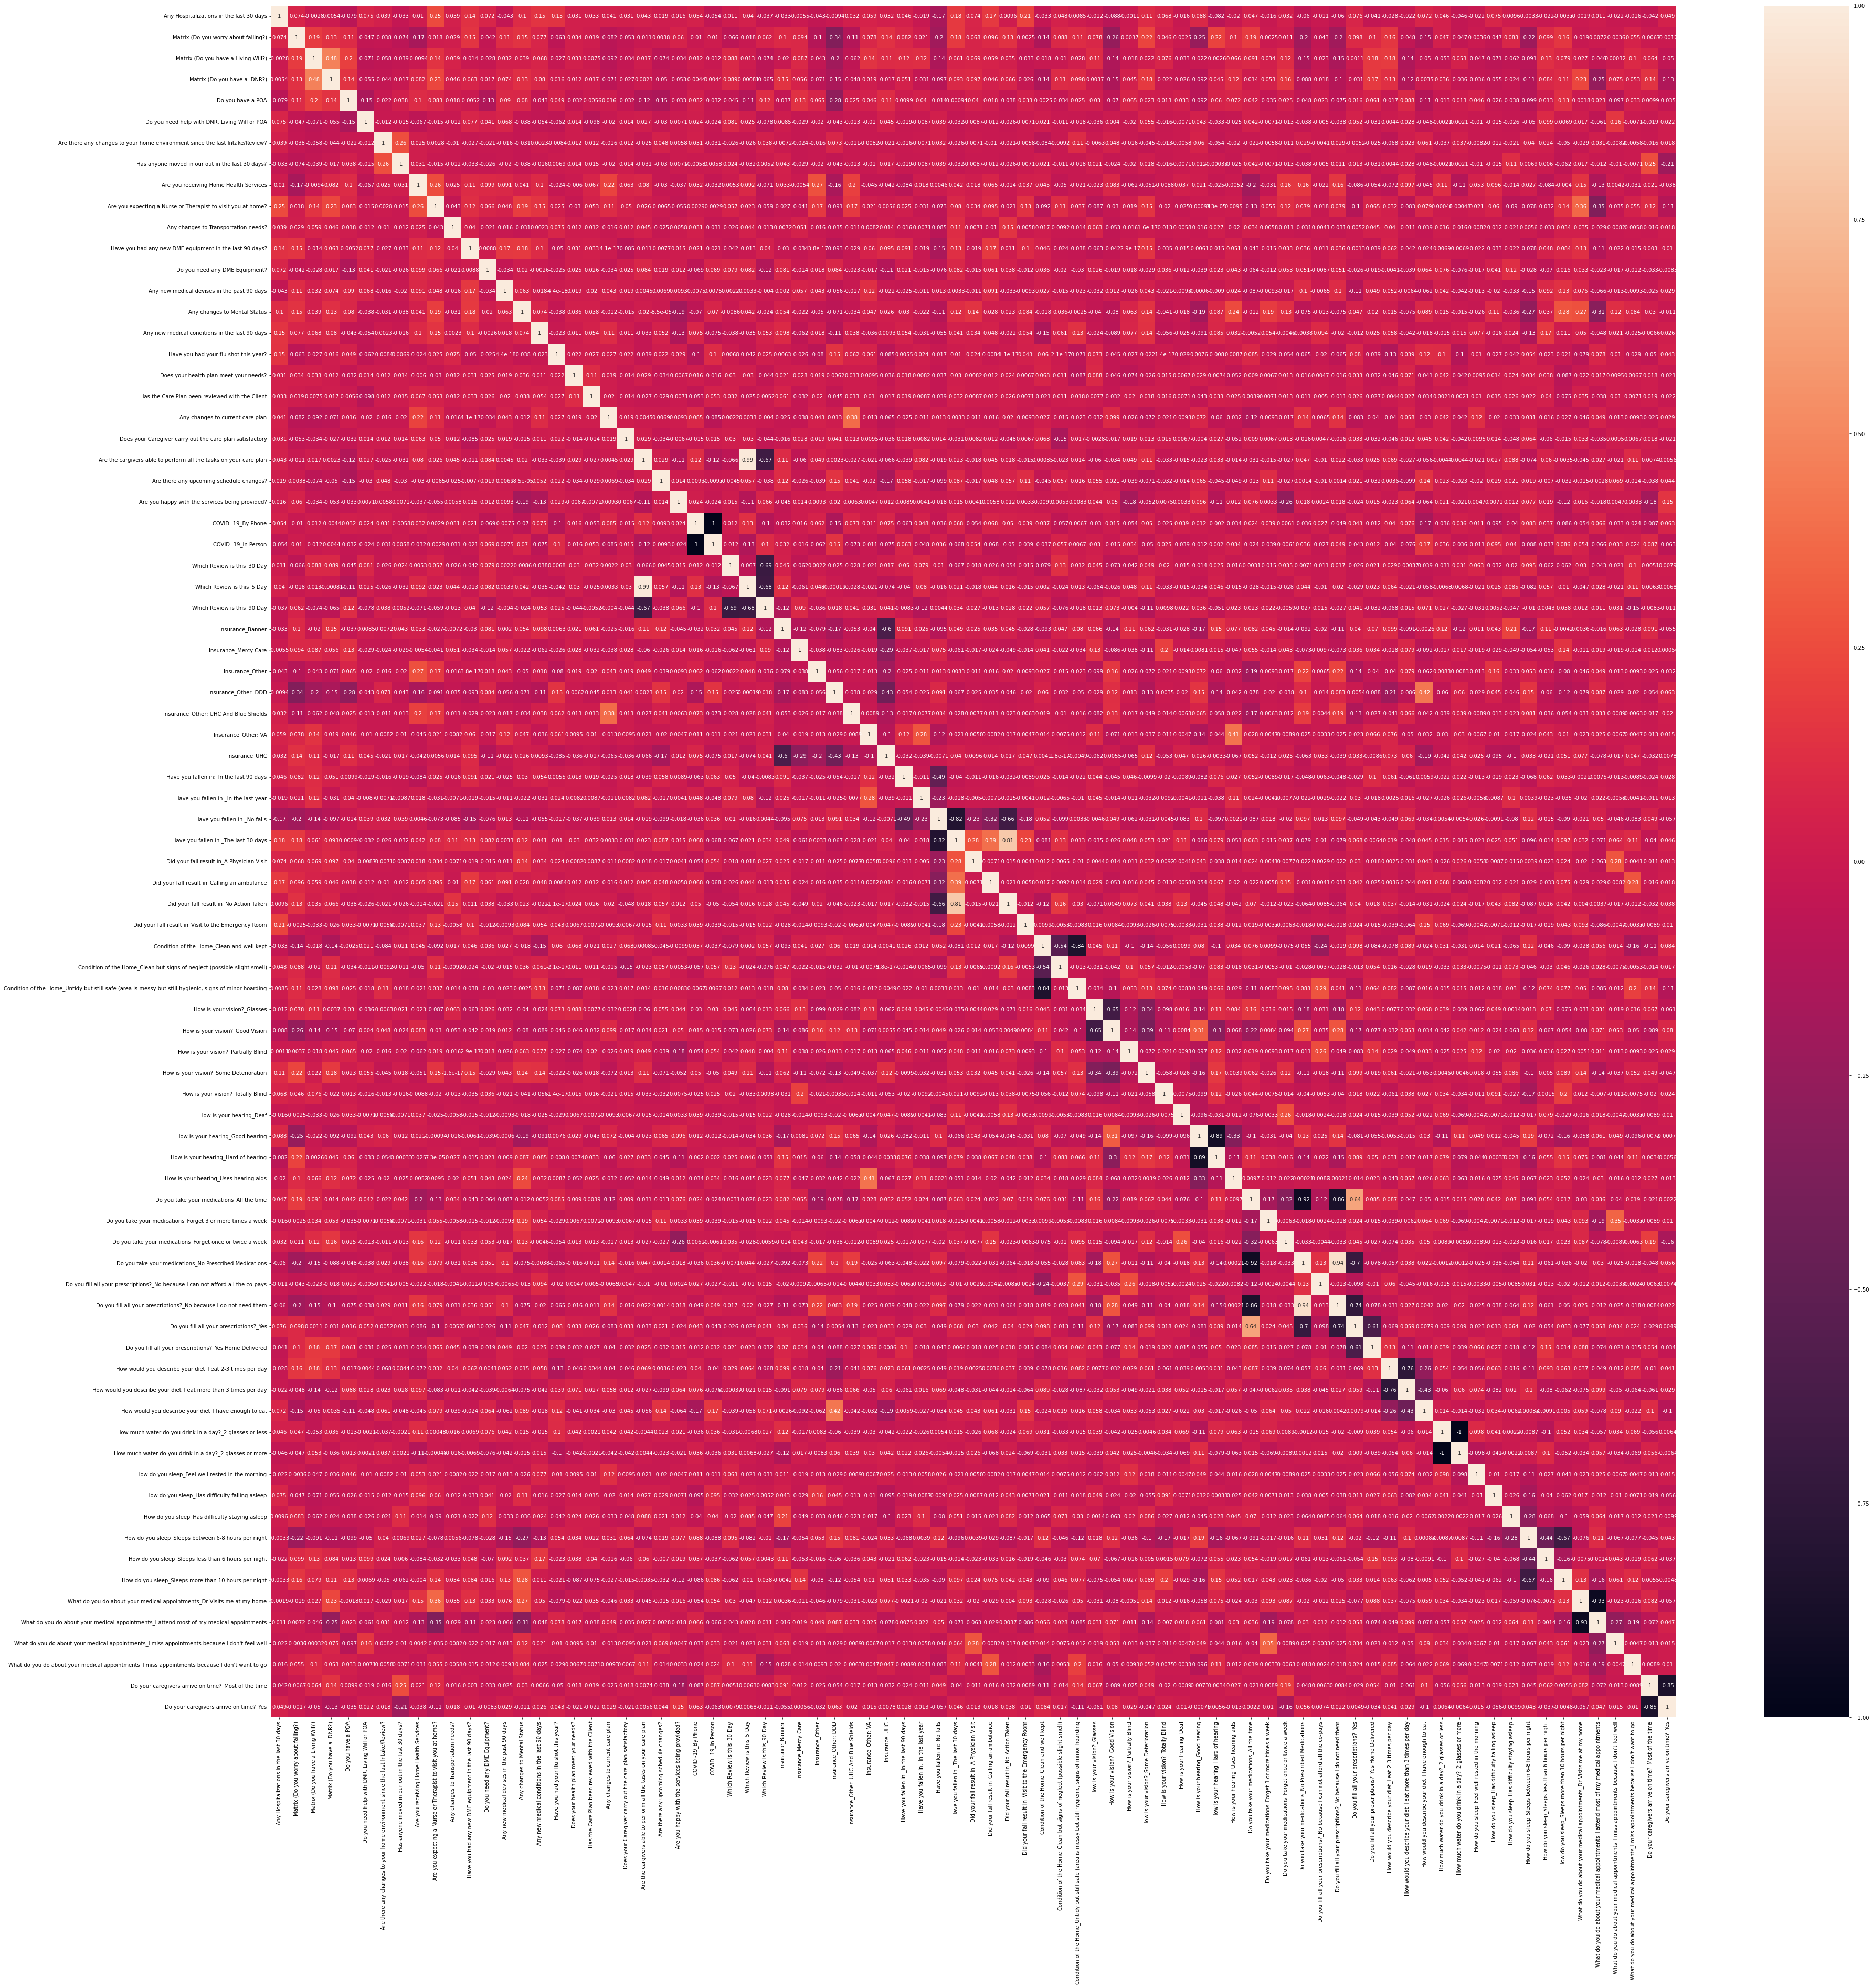

In [ ]:
#CRF self correlation
noIDCrfs = deIdCrf(crfs)
#noIDCrfs.corr()['Any Hospitalizations in the last 30 days'].sort_values(ascending=False)
plt.figure(figsize=(60,60))
sns.heatmap(noIDCrfs.corr(), annot=True)

In [ ]:
#Helper functions for adls

#Make sure to apply the proper subset to data or else there will be an excess of appointmens
def applyDiffToEntries(data, ref, compFunc, colName):
  mtData = data.copy()
  conds = mtData.apply(lambda r: compFunc(ref, r), axis=1)
  data.insert(0, colName, conds)
  return data

def iterateEntriesSorted(compDf, sortCol, **kwargs):
  compDf = compDf.sort_values(by=sortCol)
  #Find least positive
  nexPoss = compDf[sortCol]
  if(len(nexPoss) > 0):
    """
    for v in nexPoss.sort_values().unique():
      yield data.loc[mtData[sortCol] == v]
    """
    r = None
    c = None
    for i in nexPoss.index:
      v = nexPoss[i]
      if r is None or v != c:
        if r is not None:
          if 'drop' in kwargs and kwargs['drop']:
            yield compDf.loc[r].drop(columns=sortCol)
          else:
            yield compDf.loc[r]
        r = [i]
        c = v
      else:
        r.append(i)
    if 'drop' in kwargs and kwargs['drop']:
      yield compDf.loc[r].drop(columns=sortCol)
    else:
      yield compDf.loc[r]
  else:
    return None

def findAllEntries(entry, data, compFunc):
  sortData = applyDiffToEntries(data, entry, compFunc, 'CompareValue')
  return iterateEntriesSorted(sortData, 'CompareValue', drop=True)

def findNextEntries(entry, data, compFunc):
  sortData = applyDiffToEntries(data, entry, compFunc, 'CompareValue')
  return iterateEntriesSorted(sortData.loc[sortData['CompareValue'] > (0, 0)], 'CompareValue', drop=True)
  """
  if(len(nexPoss) > 0):
    #for v in nexPoss.sort_values().unique():
    #  yield data.loc[mtData['CompareValue'] == v]
    r = None
    c = None
    for i in nexPoss.index:
      v = nexPoss[i]
      if r is None or v != c:
        if r is not None:
          yield data.loc[r]
        r = [i]
        c = v
      else:
        r.append(i)
  else:
    return None
"""

#Does not account for multiple visits in a day
def adlDateDiff(adl1, adl2):
  #return ((adl2['VisitDate'] - adl1['VisitDate']).days * 24 * 60 * 60 + (adl2['ActualTimeIn'] - adl1['ActualTimeIn']).seconds) * 1000 + ((adl2['ActualTimeOut'] - adl1['ActualTimeOut']).seconds/60)
  return ((adl2['VisitDate'] - adl1['VisitDate']).days * 24 * 60 * 60 + (adl2['ActualTimeIn'] - adl1['ActualTimeIn']).seconds, (adl2['ActualTimeOut'] - adl1['ActualTimeOut']).seconds/60)

def iterateAdls(adlSub):
  return findAllEntries(adlSub.iloc[0], adlSub, adlDateDiff)

def previousAdls(adlRow, adlSub):
  return findNextEntries(adlRow, adlSub, lambda a, b: adlDateDiff(b, a))

def nextAdls(adlRow, adlSub):
  return findNextEntries(adlRow, adlSub, adlDateDiff)

def sameAptAdls(adlRow, adlSub):
  sub = adlSub.loc[(adlSub['DeIdentify ID'] == adlRow['DeIdentify ID']) &
                    (adlSub['CaregiverID'] == adlRow['CaregiverID'])]
  return sub.loc[(sub['VisitDate'] == adlRow['VisitDate']) &
                    (sub['ActualTimeIn'] == adlRow['ActualTimeIn']) &
                    (sub['ActualTimeOut'] == adlRow['ActualTimeOut'])]

In [ ]:
#CSP-3: Get ADLs for all CRFs

#Section above needs to be integrated into the current section

#print(targetCrf['Masked Client ID'])
#print(targetCrf)

def localMostRecent(crfRow, crfsSub):
  ret = None
  for i, r in crfsSub.iterrows():
    if ret is None or ((r['Date of Review'] < crfRow['Date of Review']) and (r['Date of Review'] > ret['Date of Review'])):
      ret = r
  return ret if ret is not None and not ret.equals(crfRow) else None

def getAdlsFromCrf(crfRow, adlSub, **kwargs):
  #Just until the previous crf

  prevCrf = localMostRecent(crfRow, crfs.loc[crfs['Masked Client ID'] == crfRow['Masked Client ID']])
  if('print' in kwargs and kwargs['print']):
    if(prevCrf is not None):
      print(f'CRF on {crfRow["Date of Review"]} and previous CRF on {prevCrf["Date of Review"]}')
    else:
      print(f'CRF on {crfRow["Date of Review"]}')
  filterAdls = adlSub.loc[adlSub['DeIdentify ID'] == crfRow['Masked Client ID']]
  filterAdls = filterAdls.loc[(crfRow['Date of Review'] - filterAdls['VisitDate']).dt.days > 30]
  #filterAdls.loc[(crfRow['Date of Review'] - filterAdls['VisitDate']).dt.days > 60]
  if prevCrf is not None:
    filterAdls = filterAdls.loc[filterAdls['VisitDate'] >= prevCrf['Date of Review']]
  return filterAdls

#Function to get all adls in a series for df crfSub
def adlsFromCrfs(crfSub, adlSub):
  crfAssocAdls = []
  for i, r in crfSub.iterrows():
    crfAssocAdls.append(getAdlsFromCrf(r, adlSub[adlSub['DeIdentify ID'] == r['Masked Client ID']]))
  crfAssocAdls = pd.Series(index=crfSub.index, data=crfAssocAdls)

  return crfAssocAdls.loc[crfAssocAdls.transform(lambda x: not x.empty)]

In [ ]:
#Compresses multiple adl rows into a row pertaining to a unique visit
def compressAdlApt(apt):
  comb = (apt.iloc[0]).copy()
  cInd = pd.Series(data=comb.index)
  comb = comb.drop(cInd.loc[cInd.transform(lambda x: x.startswith('Reason'))])
  cInd = pd.Series(data=comb.index)
  pSub = apt.loc[apt['Performed'] == 1]
  for i in cInd.loc[cInd.transform(lambda x: '_' in x)].values:
    comb[i] = 1 if pSub[i].any() else 0
  return comb.drop(['HasBeenDone', 'Performed'])

In [ ]:
#Turn adls into appointments

apts = []
for c in sorted(adls['DeIdentify ID'].unique()):
  sub = adls.loc[adls['DeIdentify ID'] == c]
  print(f'{c}: {len(sub)}')
  for i in iterateAdls(sub):
    apts.append(compressAdlApt(i))
#compAdls[0].index
compAdls = pd.DataFrame(columns=apts[0].index, data=apts)
print(f'Appointments: {len(compAdls)}')

Client001: 1872
Client002: 2556
Client003: 2905
Client004: 2646
Client005: 46
Client006: 4512
Client007: 1896
Client008: 2349
Client009: 5136
Client010: 1316
Client011: 597
Client012: 3880
Client013: 12370
Client015: 6825
Client016: 2793
Client017: 8166
Client018: 6840
Client019: 201
Client020: 1152
Client021: 9070
Client022: 8232
Client023: 3060
Client024: 4199
Client025: 3708
Client026: 6620
Client027: 222
Client029: 1258
Client030: 5943
Client031: 3570
Client032: 296
Client033: 4590
Client035: 2025
Client036: 6785
Client037: 1204
Client038: 8
Client040: 3997
Client041: 207
Client042: 225
Client043: 3576
Client044: 3933
Client045: 3084
Client048: 189
Client049: 468
Client050: 5460
Client051: 170
Client052: 3323
Client054: 3384
Client055: 4761
Client057: 829
Client058: 7056
Client059: 4658
Client060: 1700
Client061: 736
Client062: 1168
Client063: 1896
Client065: 1068
Client066: 4059
Client067: 1885
Client068: 703
Client069: 5328
Client070: 7672
Client072: 3190
Client075: 4020
Client07

In [ ]:
#Find invalid CRFs and ADLs and remove
allAdls = adlsFromCrfs(crfs, compAdls)
validCrfs = crfs.loc[allAdls.index]
acc = pd.DataFrame(columns=adls.columns)
for df in allAdls:
  acc = acc.merge(df, how='outer')
validCompAdls = acc
print(f'Valid Comp ADLs: {len(validCompAdls)}, Valid CRFs: {len(validCrfs)}')

Valid Comp ADLs: 34417, Valid CRFs: 475


In [ ]:
#Mask ADLs to if has valid CRF
print(f'Pre: {len(adls)}')
adls = adls.loc[adls['DeIdentify ID'].transform(lambda x: x in crfClis)]
print(f'Post: {len(adls)}')

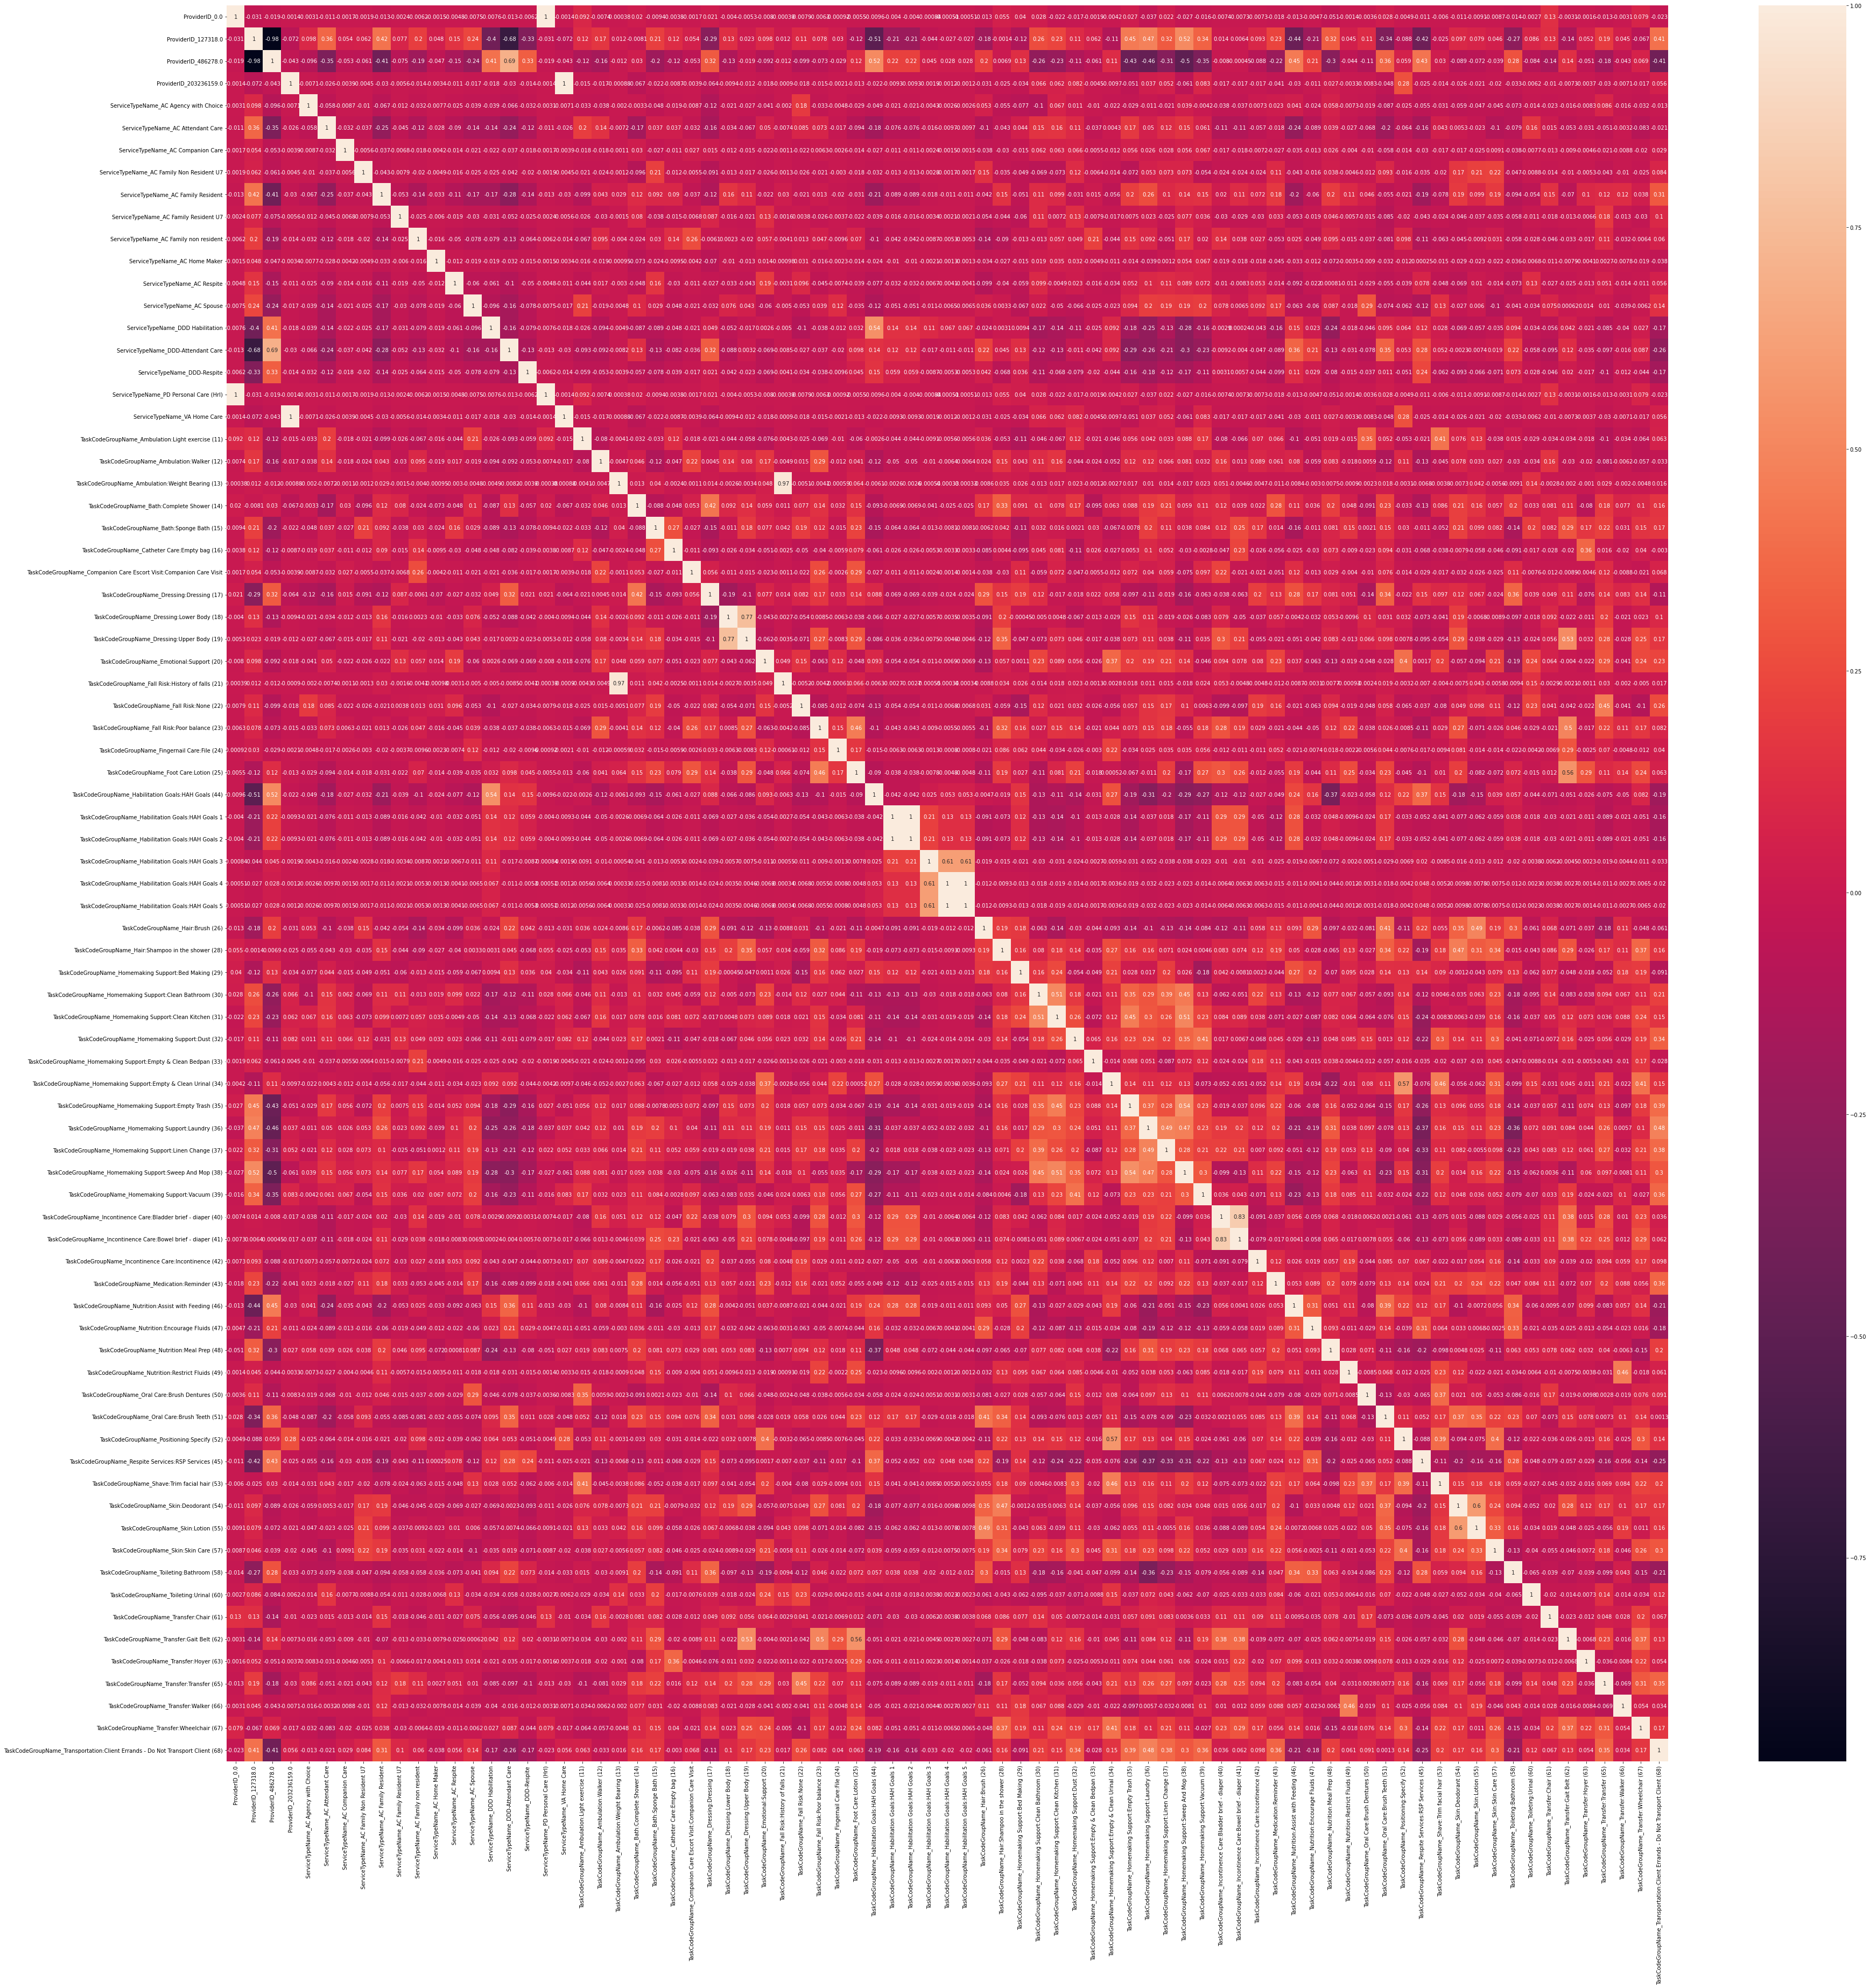

In [ ]:
plt.figure(figsize=(60,60))
sns.heatmap(deIdAdl(compAdls).corr(), annot=True)

In [ ]:
len(crfs)

475

In [ ]:
cliadls = compAdls['DeIdentify ID'].unique()
clicrfs = crfs['Masked Client ID'].unique()
print(f'Unique clients, ADLs: {len(cliadls)}, CRFs: {len(clicrfs)}, CRFless: {len(cliadls)-len(clicrfs)}')
for c in cliadls:
  if c not in clicrfs:
    print(c)

Unique clients, ADLs: 166, CRFs: 158, CRFless: 8
Client011
Client038
Client041
Client048
Client051
Client099
Client123
Client145


In [ ]:
i = 0
s = []
for ind, crf in crfs.iterrows():
  print(f'{ind}')
  if len(getAdlsFromCrf(crf)) > 0:
    i += 1
    s.append(True)
  else:
    s.append(False)
s = crfs.loc[pd.Series(s)]

In [ ]:
#crfs['Masked Client ID'].value_counts()
#s['Masked Client ID'].nunique()
#len(s)
s['Any Hospitalizations in the last 30 days'].value_counts()
r = s.loc[s['Any Hospitalizations in the last 30 days'] == 1]
#v = r['Masked Client ID'].value_counts()
#r = s.loc[s['Masked Client ID'].transform(lambda x: v[x] >= 2)]
#s['Masked Client ID'].nunique() - r['Masked Client ID'].nunique()
r['Masked Client ID'].nunique()

In [ ]:
# GET ADLS FROM CRF
getAdlsFromCrf(crfs.loc[crfs['Masked Client ID'] == 'Client001'].iloc[1], compAdls, print=True)

CRF on 2021-12-08 00:00:00 and previous CRF on 2021-09-02 00:00:00


DeIdentify ID   CaregiverID  VisitDate        ActualTimeIn  \
468     Client001  Caregiver001 2021-09-02 1900-01-01 10:00:00   
485     Client001  Caregiver001 2021-09-06 1900-01-01 10:00:00   
490     Client001  Caregiver001 2021-09-07 1900-01-01 10:00:00   
502     Client001  Caregiver001 2021-09-08 1900-01-01 10:00:00   
511     Client001  Caregiver001 2021-09-09 1900-01-01 10:00:00   
521     Client001  Caregiver001 2021-09-14 1900-01-01 10:00:00   
528     Client001  Caregiver001 2021-09-15 1900-01-01 10:00:00   
538     Client001  Caregiver001 2021-09-16 1900-01-01 10:00:00   
548     Client001  Caregiver001 2021-09-20 1900-01-01 10:00:00   
557     Client001  Caregiver001 2021-09-21 1900-01-01 10:00:00   
565     Client001  Caregiver001 2021-09-22 1900-01-01 10:00:00   
575     Client001  Caregiver001 2021-09-23 1900-01-01 10:00:00   
582     Client001  Caregiver001 2021-09-27 1900-01-01 10:00:00   
592     Client001  Caregiver001 2021-09-28 1900-01-01 10:00:00   
602     Client001  Caregiver001 2021-09-29 1900-01-01 10:00:00   
609     Client001  Caregiver001 2021-09-30 1900-01-01 10:00:00   
619     Client001  Caregiver001 2021-10-04 1900-01-01 10:00:00   
629     Client001  Caregiver001 2021-10-05 1900-01-01 10:00:00   
635     Client001  Caregiver001 2021-10-06 1900-01-01 10:00:00   
646     Client001  Caregiver001 2021-10-07 1900-01-01 10:00:00   
656     Client001  Caregiver001 2021-10-11 1900-01-01 10:00:00   
662     Client001  Caregiver001 2021-10-12 1900-01-01 10:00:00   
666     Client001  Caregiver001 2021-10-13 1900-01-01 10:00:00   
683     Client001  Caregiver001 2021-10-14 1900-01-01 10:00:00   
692     Client001  Caregiver001 2021-10-19 1900-01-01 10:00:00   
698     Client001  Caregiver001 2021-10-20 1900-01-01 10:00:00   
702     Client001  Caregiver001 2021-10-21 1900-01-01 10:00:00   
716     Client001  Caregiver001 2021-10-25 1900-01-01 10:00:00   
726     Client001  Caregiver001 2021-10-26 1900-01-01 11:00:00   
737     Client001  Caregiver001 2021-10-27 1900-01-01 10:00:00   
746     Client001  Caregiver001 2021-10-28 1900-01-01 10:00:00   
752     Client001  Caregiver001 2021-11-01 1900-01-01 10:00:00   
764     Client001  Caregiver001 2021-11-02 1900-01-01 10:00:00   
773     Client001  Caregiver001 2021-11-03 1900-01-01 10:00:00   
782     Client001  Caregiver001 2021-11-04 1900-01-01 10:00:00   

          ActualTimeOut  ProviderID_0.0  ProviderID_127318.0  \
468 1900-01-01 13:00:00               0                    0   
485 1900-01-01 13:00:00               0                    0   
490 1900-01-01 13:00:00               0                    0   
502 1900-01-01 13:00:00               0                    0   
511 1900-01-01 13:00:00               0                    0   
521 1900-01-01 13:00:00               0                    0   
528 1900-01-01 13:00:00               0                    0   
538 1900-01-01 13:00:00               0                    0   
548 1900-01-01 13:00:00               0                    0   
557 1900-01-01 13:00:00               0                    0   
565 1900-01-01 13:00:00               0                    0   
575 1900-01-01 13:00:00               0                    0   
582 1900-01-01 12:00:00               0                    0   
592 1900-01-01 13:00:00               0                    0   
602 1900-01-01 13:00:00               0                    0   
609 1900-01-01 13:00:00               0                    0   
619 1900-01-01 13:00:00               0                    0   
629 1900-01-01 13:00:00               0                    0   
635 1900-01-01 13:00:00               0                    0   
646 1900-01-01 13:00:00               0                    0   
656 1900-01-01 13:00:00               0                    0   
662 1900-01-01 13:00:00               0                    0   
666 1900-01-01 13:00:00               0                    0   
683 1900-01-01 13:00:00               0                    0   
692 1900-01-01 13:00:00    

In [ ]:
compAdls.columns

Index(['DeIdentify ID', 'CaregiverID', 'VisitDate', 'ActualTimeIn',
       'ActualTimeOut', 'ProviderID_127318.0', 'ProviderID_486278.0',
       'ProviderID_203236159.0', 'ServiceTypeName_AC Agency with Choice',
       'ServiceTypeName_AC Attendant Care',
       'ServiceTypeName_AC Companion Care',
       'ServiceTypeName_AC Family Non Resident U7',
       'ServiceTypeName_AC Family Resident',
       'ServiceTypeName_AC Family Resident U7',
       'ServiceTypeName_AC Family non resident',
       'ServiceTypeName_AC Home Maker', 'ServiceTypeName_AC Respite',
       'ServiceTypeName_AC Spouse', 'ServiceTypeName_DDD Habilitation',
       'ServiceTypeName_DDD-Attendant Care', 'ServiceTypeName_DDD-Respite',
       'ServiceTypeName_VA Home Care',
       'TaskCodeGroupName_Ambulation:Light exercise (11)',
       'TaskCodeGroupName_Ambulation:Walker (12)',
       'TaskCodeGroupName_Bath:Complete Shower (14)',
       'TaskCodeGroupName_Bath:Sponge Bath (15)',
       'TaskCodeGroupName_Catheter 

In [ ]:
compAdls.to_csv('outreachAppointmentAdls.csv', index=False, header=True)

# Scratch after this cell

In [ ]:
#Comment cell

#pd.set_option('display.max_rows', None)

In [ ]:
if runScratchSections:
  #TODO this targets a specific client and carer, make general
  #adls.loc[adls['TaskCodeGroupName'].transform(lambda x: not isinstance(x, str))]
  #debug = adls.loc[(adls['DeIdentify ID'] == 'Client017') & (adls['CaregiverID'] == 'Caregiver026')]
  noRzn = adls.loc[adls['TaskCodeGroupName'].transform(lambda x: not isinstance(x, str))]
  withs = noRzn.apply(lambda x: len(sameAptAdls(x, adls)), axis=1)
  #print(f'Size: {len(withs)}, Sum: {withs.sum() if len(withs) > 0 else 0}')
  if len(withs) > 0 and len(withs) < withs.sum():
    for i, r in noRzn.iterrows():
      print(f'Running row {i}')
      #Client + carer subset vs client subset
      cliCarSub = adls.loc[(adls['DeIdentify ID'] == r['DeIdentify ID']) & (adls['CaregiverID'] == r['CaregiverID'])]
      apt = sameAptAdls(r, cliCarSub)
      aptNoRzn = sameAptAdls(r, noRzn)
      #Check same in 2? ways or maybe do a time difference
      together = 0
      #Need to change adls to caregiver subset
      for nApts in previousAdls(r, cliCarSub):
        otherTasks = nApts['TaskCodeGroupName'].loc[nApts['TaskCodeGroupName'].transform(lambda x: isinstance(x, str))]
        taskAmt = len(otherTasks)
        otherTasks = otherTasks.unique()
        #Do an and vs or?
        if len(nApts) - taskAmt == len(apt) - len(aptNoRzn) or nApts.apply(lambda x: x['TaskCodeGroupName'] in otherTasks, axis=1).all():
          together += 1
        else:
          break
      for nApts in nextAdls(r, cliCarSub):
        otherTasks = nApts['TaskCodeGroupName'].loc[nApts['TaskCodeGroupName'].transform(lambda x: isinstance(x, str))]
        taskAmt = len(otherTasks)
        otherTasks = otherTasks.unique()
        #Do an and vs or?
        if len(nApts) - taskAmt == len(apt) - len(aptNoRzn) or nApts.apply(lambda x: x['TaskCodeGroupName'] in otherTasks, axis=1).all():
          together += 1
        else:
          break
      print(f'Index: {r.index}, Together: {together}')
      if together >= 2:
        #Remove extras
        print('Remove extras')
      else:
        #Remove apt with empties
        print('Remove whole apt')
        #adls = adls.drop(r)

      #print(apt['VisitDate'])
  #debug = debug.loc[debug['VisitDate'] == datetime.datetime(day=12, month=6, year=2021)]
  ##debug['CaregiverID'].unique()
  #debug.iloc[2]['VisitDate']
  #debug
else:
  print('RunScratchSections is false')

RunScratchSections is false


In [ ]:
if runScratchSections:
  #CSP-6: Find and correct invalid data

  """
  adls = adls.loc[(adls['Caregiver ID'] != 'Caregiver051') | (adls['DeIdentify ID'] != 'Client035')]
  adls = adls.loc[(adls['Caregiver ID'] != 'Caregiver053') | (adls['DeIdentify ID'] != 'Client038')]
  """

  print(f'Pre: {len(adls)}')

  #Delete each Client + Caregiver all no TaskCodeGroupName
  noRznAdls = adls.loc[adls['TaskCodeGroupName'].transform(lambda x: not isinstance(x, str))]
  for carer in noRznAdls['CaregiverID'].unique():
    cliRows = adls.loc[adls['CaregiverID'] == carer]
    refRow = cliRows.iloc[0]
    #debug = cliRows['TaskCodeGroupName'].transform(lambda x: not isinstance(x, str))
    #print('TS: ' + str(debug) + ' A: ' + str(debug.all()))
    noRzn = cliRows.loc[cliRows['TaskCodeGroupName'].transform(lambda x: not isinstance(x, str))]
    if len(noRzn) == len(cliRows):
      #print(f'Removing cli {refRow['DeIdentify ID']} carer {refRow['CaregiverID']}')
      print('Removing cli ' + refRow['DeIdentify ID'] + ' carer ' + refRow['CaregiverID'])
      #print(refRow)
      adls = adls.loc[(adls['DeIdentify ID'] != refRow['DeIdentify ID']) | (adls['CaregiverID'] != refRow['CaregiverID'])]
    for i, r in noRzn.iterrows():
      #print(r)
      if i in adls.index:
        sameApt = cliRows.loc[(cliRows['DeIdentify ID'] == r['DeIdentify ID']) &
                              (cliRows['CaregiverID'] == r['CaregiverID']) &
                              (cliRows['VisitDate'] == r['VisitDate'])]
        if sameApt.apply(lambda y: not isinstance(y['TaskCodeGroupName'], str), axis=1).all():
          #Appointment is all tasks not specified
          print(f'Removing empty task apts {list(sameApt.index)}')
          adls = adls.drop(list(sameApt.index))
    

  #ADL 12920
  #inv = adls.iloc[12920]
  #inv
  #inv = adls.loc[adls['TaskCodeGroupName'].transform(lambda x: type(x)) != type(str())]
  #inv['Caregiver ID'].value_counts()
  #inv = inv.loc[inv['Caregiver ID'] == 'Caregiver183']
  #inv['DeIdentify ID'].value_counts()
  #inv.head(25)
  #Client035 Caregiver051
  #oths = adls.loc[(adls['DeIdentify ID'] == 'Client038') & (adls['Caregiver ID'] == 'Caregiver053')]
  #oths = adls.loc[(adls['DeIdentify ID'] == 'Client035')]
  #len(oths)
  #len(inv)
  #len(oths) - len(inv)
  print(f'Post: {len(adls)}')
else:
  print('RunScratchSections is false')

RunScratchSections is false
